# Model training on sample data

## 1. Initialisation 

### Libraries imports

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import os
from PIL import Image

### Image importation

In [6]:
def load_images_from_folder(folder, target_size=(224, 224)):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                img_path = os.path.join(label_path, filename)
                if img_path.endswith(('.JPG')):
                    img = Image.open(img_path).convert('L')  # Convert to grayscale
                    img = img.resize(target_size)  # Resize to target size
                    img = np.array(img) / 255.0  # Normalize to [0, 1]
                    images.append(img)
                    labels.append(label)
    return np.array(images), np.array(labels)

def prepare_data(train_folder, test_folder, target_size=(224, 224)):
    # Load images and labels
    X_train, y_train = load_images_from_folder(train_folder, target_size)

    X_test, y_test = load_images_from_folder(test_folder, target_size)

    # Encode labels as integers
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.transform(y_test)

    y_train_cat = to_categorical(y_train)
    y_test_cat = to_categorical(y_test)

    # Reshape images to match the format (num_samples, height, width)
    X_train = X_train.reshape((X_train.shape[0], target_size[0], target_size[1]))
    X_test = X_test.reshape((X_test.shape[0], target_size[0], target_size[1]))

    return (X_train, y_train_cat), (X_test, y_test_cat), label_encoder 

# Example usage
train_folder = '../data_samples/train'
test_folder = '../data_samples/test'

(X_train, y_train), (X_test, y_test), label_encoder  = prepare_data(train_folder, test_folder)

print(f'Training data shape: {X_train.shape}')
print(f'Test data shape: {X_test.shape}')

Training data shape: (5105, 224, 224)
Test data shape: (5057, 224, 224)


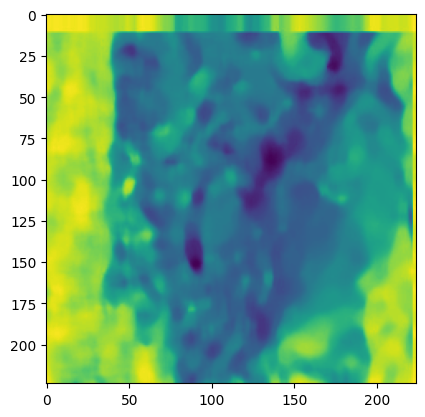

In [7]:
# Display an image from the training set
plt.imshow(X_train[0])

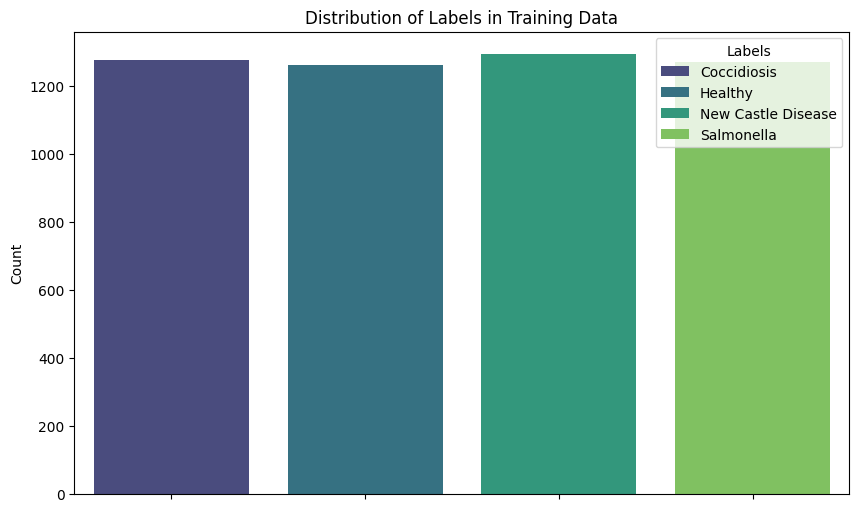

In [8]:
# Count the occurrences of each label
unique_labels, counts = np.unique(y_train.argmax(axis=1), return_counts=True)

# Ensure unique_labels are integers
unique_labels = unique_labels.astype(int)

# Map integer labels back to original string labels
label_names = label_encoder.inverse_transform(unique_labels)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=label_names, y=counts, hue=label_names, palette='viridis', dodge=False, legend=True)

# Adding titles and labels
plt.title('Distribution of Labels in Training Data')
plt.ylabel('Count')
plt.xticks(ticks=range(len(label_names)), labels=[''] * len(label_names))  # Set x-axis labels to empty
plt.legend(title='Labels', loc='upper right')  # Display legend
plt.show()

In [9]:
# Reshape the data for CNN input For grayscale images
X_train = X_train.reshape(X_train.shape[0], 224, 224, 1)  # Add channel dimension for grayscale
X_test = X_test.reshape(X_test.shape[0], 224, 224, 1)  # Add channel dimension for grayscale

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [11]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(4,4), strides=(1,1), activation='relu', input_shape=(224, 224, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))

# Keras.io/metrics
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [14]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/10
160/160 [==============================] - 41s 258ms/step - loss: 3.2729 - accuracy: 0.2962 - val_loss: 1.3500 - val_accuracy: 0.3431
Epoch 2/10
160/160 [==============================] - 40s 248ms/step - loss: 1.3144 - accuracy: 0.3706 - val_loss: 1.3531 - val_accuracy: 0.3639
Epoch 3/10
160/160 [==============================] - 40s 250ms/step - loss: 1.1989 - accuracy: 0.4842 - val_loss: 1.3100 - val_accuracy: 0.3830
Epoch 4/10
160/160 [==============================] - 41s 259ms/step - loss: 1.0187 - accuracy: 0.5826 - val_loss: 1.3765 - val_accuracy: 0.3994
Epoch 5/10
160/160 [==============================] - 41s 259ms/step - loss: 0.7915 - accuracy: 0.7064 - val_loss: 1.5245 - val_accuracy: 0.4509
Epoch 6/10
160/160 [==============================] - 42s 263ms/step - loss: 0.6282 - accuracy: 0.7853 - val_loss: 1.6070 - val_accuracy: 0.4453


<Axes: >

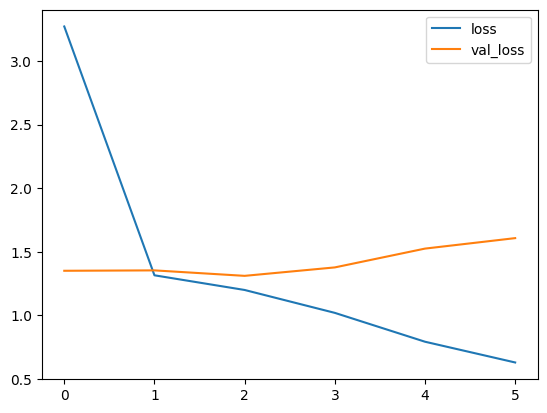

In [17]:
metrics = pd.DataFrame(model.history.history)
metrics[['loss', 'val_loss']].plot()

<Axes: >

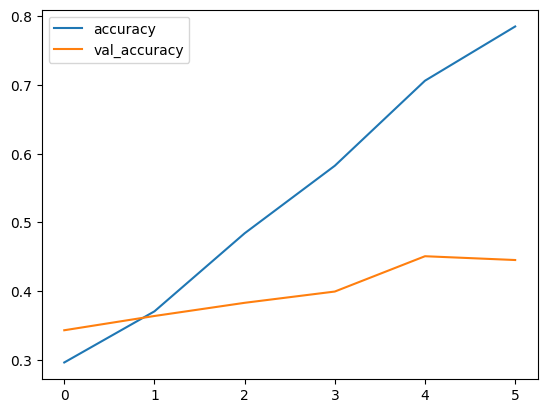

In [18]:
metrics[['accuracy', 'val_accuracy']].plot()

In [19]:
model.evaluate(X_test, y_test)

159/159 [==============================] - 8s 48ms/step - loss: 1.6070 - accuracy: 0.4453


[1.6069773435592651, 0.44532331824302673]

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
predictions = np.argmax(model.predict(X_test),axis=1)
print(classification_report(np.argmax(y_test, axis=1), predictions, target_names=label_encoder.classes_))

159/159 [==============================] - 8s 48ms/step
                    precision    recall  f1-score   support

       Coccidiosis       0.58      0.50      0.54      1273
           Healthy       0.55      0.34      0.42      1254
New Castle Disease       0.37      0.47      0.41      1272
        Salmonella       0.38      0.47      0.42      1258

          accuracy                           0.45      5057
         macro avg       0.47      0.44      0.45      5057
      weighted avg       0.47      0.45      0.45      5057



In [23]:
confusion_matrix(np.argmax(y_test, axis=1),  predictions)

array([[635, 105, 269, 264],
       [112, 426, 403, 313],
       [155, 135, 603, 379],
       [192, 102, 376, 588]], dtype=int64)

<Axes: >

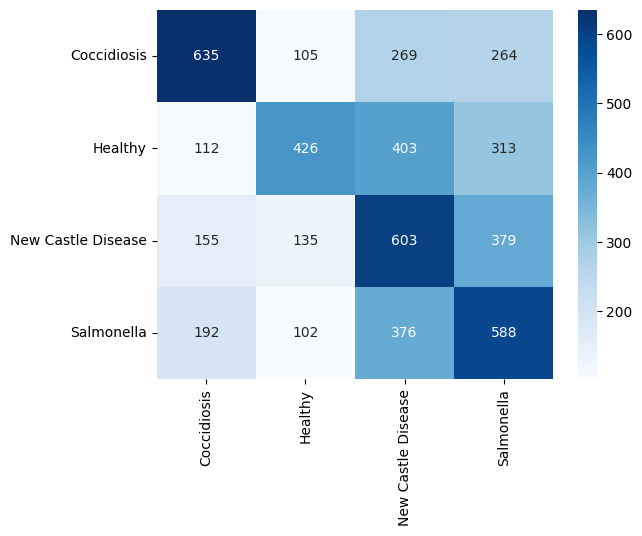

In [28]:
import seaborn as sns 
sns.heatmap(confusion_matrix(np.argmax(y_test, axis=1),  predictions), annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)